# Classifier Model Fitting and Evaluation

This notebook focuses on fitting and evaluating a machine learning classifier. The aim is to demonstrate the process of training a model on prepared data, evaluating its performance using key metrics, and analyzing the results to assess its effectiveness.


In [1]:
# Importing Python Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#read the dataset
df = pd.read_csv('../Data/Data_cleaned')
df.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,y_no,y_yes
0,1.712900,0.482038,-1.309555,0.033408,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.339795,-0.543393,-1.309555,-0.416710,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.739073,-0.556490,-1.309555,-0.723609,-0.614612,-0.371844,-0.344067,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,-0.542916,-0.445410,-1.309555,-0.465814,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,-1.229468,-0.340635,-1.309555,-0.146639,-0.614612,-0.371844,-0.344067,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [3]:
#Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
X=df.drop(columns=['y_yes','y_no'])
y=df['y_yes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape

(32948, 43)

## Downsampling the Training Data

Class imbalance in datasets can lead to biased models that favor the majority class. To address this, we use **downsampling** to balance the class distribution by reducing the size of the majority class.
In our case , we have 29407 samples of class 0 and 3541 samples of class 1.

**Benefits**
- Balanced Classes: Prevents the model from favoring the majority class.  
- Improved Learning: Focuses on distinguishing between classes.  
- Efficiency: Reduces computational overhead.

**Process**
1. Inspect Class Distribution: Identify the size of each class.  
2. Downsample Majority Class: Randomly reduce its size to match the minority class.  
3. Combine and Shuffle: Merge both classes and shuffle the dataset to remove ordering bias.

This approach creates a balanced training set, ensuring fair model learning across both classes.


In [4]:
from sklearn.utils import resample, shuffle


# Check class distribution
print(y_train.value_counts())

# Separate the majority and minority classes
X_train_0 = X_train[y_train == 0]  # Features for class 0
X_train_1 = X_train[y_train == 1]  # Features for class 1

# Downsample the majority class (class 0 in this case)
X_train_0_downsampled = resample(
    X_train_0,
    replace=False,                       # Sample without replacement
    n_samples=len(X_train_1),            # Match minority class count
    random_state=42                      # Ensure reproducibility
)

# Combine the downsampled majority class with the minority class
X_train_downsample = pd.concat([X_train_0_downsampled, X_train_1], axis=0)

# Create corresponding target labels
y_train_0_downsampled = pd.Series(0, index=X_train_0_downsampled.index)  # Label 0
y_train_1 = pd.Series(1, index=X_train_1.index)                         # Label 1

# Combine the downsampled labels
y_train_downsample = pd.concat([y_train_0_downsampled, y_train_1], axis=0)

# Shuffle the downsampled dataset to avoid ordering bias
X_train_downsample, y_train_downsample = shuffle(X_train_downsample, y_train_downsample, random_state=42)

print(f'X_train shape : {X_train_downsample.shape} | y_train shape : {X_train_downsample.shape}')


y_yes
0    29407
1     3541
Name: count, dtype: int64
X_train shape : (7082, 43) | y_train shape : (7082, 43)


# Expriments

## Knn Classifier

### Fitting

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier(n_neighbors=5)
knn

KNeighborsClassifier()

In [6]:
# Define the parameter grid
parameter_grid = {
    "n_neighbors": range(1, 100, 5),
}

# Perform grid search
grid_search = GridSearchCV(estimator=knn, param_grid=parameter_grid, cv=5)
grid_search.fit(X_train_downsample,y_train_downsample)
experiment1_knn=grid_search.best_estimator_

In [7]:
# Print the best parameters and the corresponding accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score

experiment1_knn.fit(X_train_downsample, y_train_downsample)
y_test_predict=experiment1_knn.predict(X_test)

accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='binary')
recall = recall_score(y_test, y_test_predict, average='binary')
f1 = f1_score(y_test, y_test_predict, average='binary')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.84
Precision: 0.38
Recall: 0.80
F1-Score: 0.52


### Results
The model achieved an **accuracy of 84%**, suggesting it correctly classified most samples. However, other metrics reveal important imbalances:

1. **Precision (0.38)**:  
   - A low precision indicates a high false positive rate, meaning the model frequently misclassifies negative samples as positive.

2. **Recall (0.80)**:  
   - The high recall shows that the model effectively identifies most positive samples but sacrifices precision in the process.

3. **F1-Score (0.52)**:  
   - The F1-score, which balances precision and recall, is relatively low, reflecting an imbalance in the model's ability to correctly classify positives without excessive false positives.


## XGBoost Classifier

XGBoost is a highly effective classifier for this problem due to its ability to handle imbalanced datasets, improve model accuracy through boosting, and provide flexibility with hyperparameters to fine-tune the model for better recall. Since the focus is on predicting clients who will subscribe to a term deposit (positive class), XGBoost's built-in advantages make it an excellent choice to maximize recall while maintaining a balanced performance.

### Fitting

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize XGBoost model
model_xgb = XGBClassifier(random_state=42, scale_pos_weight=len(y_train_downsample) / sum(y_train_downsample))

# Train the model
model_xgb.fit(X_train_downsample, y_train_downsample)

# Predictions
y_test_predict_xgb = model_xgb.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_test_predict_xgb)
precision_xgb = precision_score(y_test, y_test_predict_xgb, average='binary')
recall_xgb = recall_score(y_test, y_test_predict_xgb, average='binary')
f1_xgb = f1_score(y_test, y_test_predict_xgb, average='binary')

print(f"Accuracy (XGBoost): {accuracy_xgb:.2f}")
print(f"Precision (XGBoost): {precision_xgb:.2f}")
print(f"Recall (XGBoost): {recall_xgb:.2f}")
print(f"F1-Score (XGBoost): {f1_xgb:.2f}")


Accuracy (XGBoost): 0.82
Precision (XGBoost): 0.36
Recall (XGBoost): 0.90
F1-Score (XGBoost): 0.51


### Feature Importance - SHAP

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


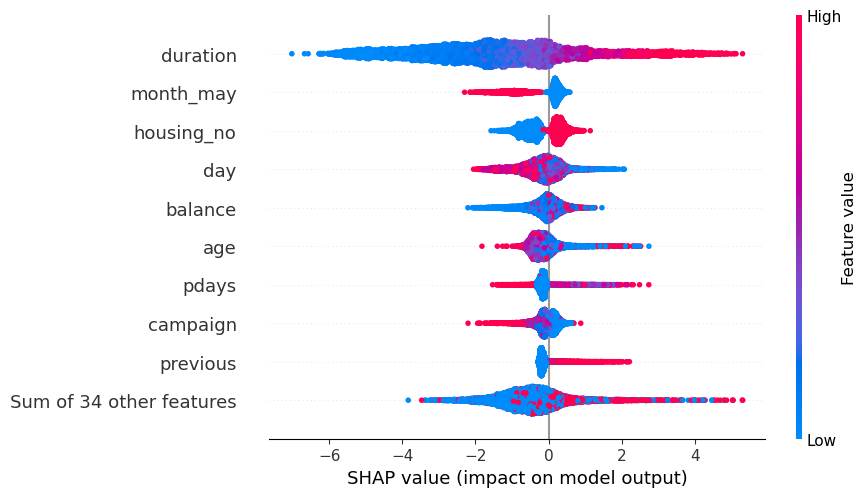

In [9]:
import shap

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test, approximate=False)

explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test,
    feature_names=X_test.columns.values
)

shap.plots.beeswarm(explanation)



# Results of the experiment

The goal of the model is to predict whether a client will subscribe to a term deposit (positive class), based on various client characteristics and marketing campaign data. In this case, the model has achieved a high **recall (0.90)**, meaning it does a good job of identifying clients who are likely to subscribe. However, this is achieved at the cost of low precision (0.36), meaning the model is also incorrectly identifying many clients who will not subscribe as positive (false positives).

This imbalance between precision and recall is a concern in scenarios where recall is more important than precision. In the context of a banking marketing campaign, **high recall is crucial because the model’s primary aim is to ensure that as many potential clients as possible are contacted about the term deposit offer**.

**Current Metrics:**
- Accuracy: 82%
- Precision: 0.36 (indicating a high rate of false positives)
- Recall: 0.90 (indicating the model identifies most potential subscribers)
- F1-Score: 0.51 (low due to the trade-off between precision and recall)



# Key Influential Features
   - **duration**: is one of the most significant features. Longer durations are strongly correlated with higher chances of the client subscribing to the term deposit, which makes sense as a longer conversation might indicate more interest and engagement from the client.
   - **month_may**: The **positive SHAP values** when May is selected show that marketing campaigns in May have a higher likelihood of success.
   - **balance**: Clients with **higher balances** are more likely to subscribe to the term deposit, as seen in the spread of SHAP values for this feature.
   - **housing**: Clients with **housing loans** (indicated by `housing_no`) are more likely to respond positively to marketing efforts, possibly indicating a connection between financial stability and interest in additional banking products like term deposits.




# Export Best Model

In [10]:
import pickle as pkl
with open('../models/customer_susbcription_classifier.pkl', 'wb') as file:
    pkl.dump(model_xgb, file)

Use the code bellow to load the model

```
import pickle as pkl

with open('../models/customer_susbcription_classifier.pkl', 'rb') as file:
    loaded_model = pkl.load(file)
```